# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
with open('ultimate_data_challenge.json') as d:
    data= json.load(d)

data= pd.DataFrame(data)

In [3]:
data.shape

(50000, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [6]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [7]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


We need to convert Signup_data and last_trip_date to datatime format since they are currently stored as string objects

In [8]:
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.signup_date=pd.to_datetime(data.signup_date)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
data.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Let us create a field trips_in_last_30_days. This is a boolean field with 1 for a trip in last 30 days(active) or 0 for no trip in last 30days (inactive)

In [11]:
data['retained'] = (data.last_trip_date >= '2014-06-01')*1
data['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

Let us calculate the rate of retention of users. i.e the active users.


In [12]:
active_users = data['retained'].sum()/data['retained'].count() * 100
active_users

37.608000000000004

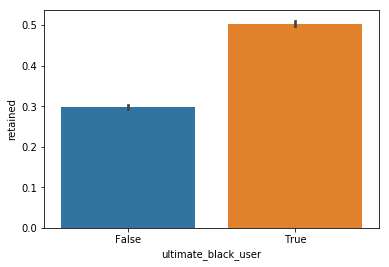

In [13]:
sns.barplot(x='ultimate_black_user',y='retained',data=data)

The above plot suggests that the ultimate black users have a higher tndency of staying.

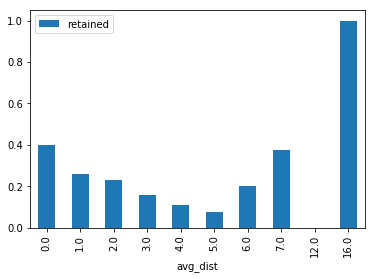

In [14]:
avg_dist_status= pd.concat([data.avg_dist//10,data.retained],axis = 1).groupby('avg_dist').mean()
avg_dist_status.plot(kind='bar')

As you can see from above, there is high retention rate amonnst users who travel longer distances on average.

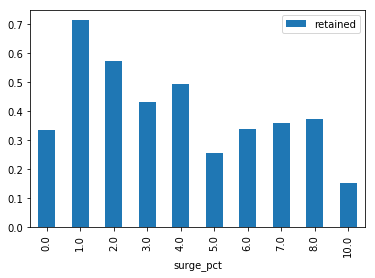

In [15]:
surge_pct_status=pd.concat([data.surge_pct//10,data.retained],axis=1).groupby('surge_pct').mean()
surge_pct_status.plot(kind='bar')

As you can see from the above chart, there is a high tendency for retention when the surge percentanges are below 5.

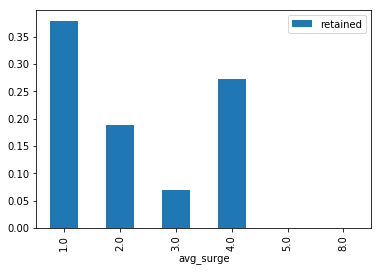

In [16]:
avg_surge_status= pd.concat([data.avg_surge//1,data.retained],axis=1).groupby('avg_surge').mean()
avg_surge_status.plot(kind='bar')

As you can see, retention for users with average surge less than 2 is the highest.

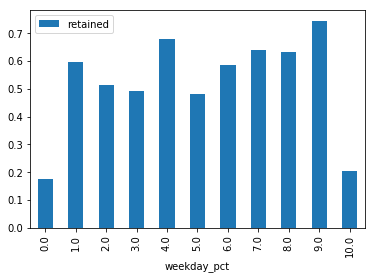

In [17]:
weekday_pct_status= pd.concat([data.weekday_pct//10,data.retained],axis=1).groupby('weekday_pct').mean()
weekday_pct_status.plot(kind='bar')

Lower weekday percentage means that users do not use ultimate service often. Higher weekday percentage means the user uses ultimate service often.

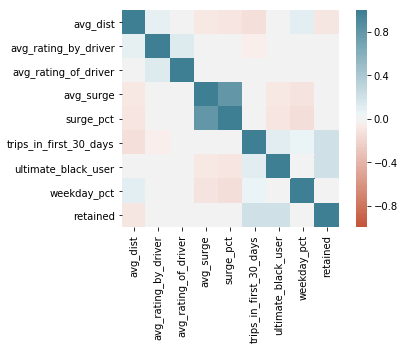

In [18]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr,vmin=-1,vmax=1,center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

In [19]:
corr['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: retained, dtype: float64

As we can see from the correlation map above, the trips_is_last_30_days is mostly correlated to trips_in_first_30_days and ultimate_black_user.




#### Data Cleaning

In [20]:
# Drop no neccessary columns
data.drop(['avg_rating_by_driver','avg_rating_of_driver','phone','last_trip_date','signup_date'], axis = 1, inplace=True)

In [21]:
#Convert ultimate black users from boolean to integers
data.ultimate_black_user =data.ultimate_black_user *1


#Label cities as 1,2,3

city_map = {"King's Landing":1, 'Astapor':2, 'Winterfell':3}
data.city = data.city.map(city_map)

# Seperate avg_dist into 10 parts
data.avg_dist = pd.qcut(data.avg_dist, 10, labels = range(1,11))

# Seperate avg_surge into 8 parts
data.avg_surge = data.avg_surge//1

# Separate surge_pct into 10 parts
data.surge_pct = data.surge_pct//10

# Separate weekday_pct into 10 parts
data.weekday_pct = data.weekday_pct//10

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
avg_dist                  50000 non-null category
avg_surge                 50000 non-null float64
city                      50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: category(1), float64(3), int64(4)
memory usage: 2.7 MB


In [23]:
# Convert columns to int type
for i in data.columns:
    data[i] = data[i].astype(int)
    
# Make sure no null values
assert data.isnull().sum().sum()==0

In [24]:
data.head()

,avg_dist,avg_surge,city,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,5,1,1,1,4,1,4,1
1,9,1,2,0,0,0,5,0
2,1,1,2,0,3,0,10,0
3,3,1,1,2,9,1,8,1
4,4,1,3,1,14,0,8,0


We are now ready for the modelling.

### Part 2 

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In this part, we compared the performance of random forest, knn, svc, and gradient boosting.

In [25]:
from sklearn.model_selection import train_test_split
xdata = data.drop('retained', axis = 1).values
ydata = data.retained
X_train,X_test,y_train,y_test= train_test_split(xdata,ydata, test_size=0.3,random_state=1)


In [26]:
# Import model evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve

# Define model evaluation method
def model_test(model, ytest, y_predict):
    print('The accuracy of {} model is: {:.2f}'.format(model, accuracy_score(ytest, y_predict)))
    print('The confusion matrix is:\n{}'.format(confusion_matrix(ytest, y_predict)))
    print('The auc score is: {:.2f}'.format(roc_auc_score(ytest, y_predict)))
    print('The F1-score is: {:.2f}'.format(f1_score(ytest, y_predict)))

# Define auc plotting method
def plot_roc(model, ytest, y_predict, y_predict_prob):
    fpr, tpr, _ = roc_curve(ytest, y_predict_prob)
    plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr, label = 'AUC score by {}: {:.2f}'.format(model, roc_auc_score(ytest, y_predict)))
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'best')
    plt.xlim(0,1)
    plt.ylim(0,1)

### Random Forests

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
rf_predict_prob = rf.predict_proba(X_test)[:,1]

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
model_test('Random Forest', y_test, rf_predict)

The accuracy of Random Forest model is: 0.73
The confusion matrix is:
[[7664 1627]
 [2496 3213]]
The auc score is: 0.69
The F1-score is: 0.61


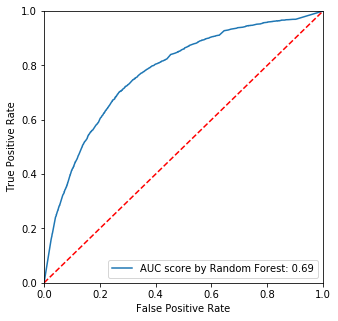

In [29]:
plot_roc('Random Forest',y_test, rf_predict,rf_predict_prob)

In [30]:
data.columns

Index(['avg_dist', 'avg_surge', 'city', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'retained'],
      dtype='object')

In [31]:
rf.feature_importances_

array([0.17966158, 0.00491407, 0.13024488, 0.09444583, 0.21865764,
       0.05557153, 0.31650446])

#### SVC

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_train)
xtrain_transform = scale.transform(X_train)
xtest_transform = scale.transform(X_test)

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
svc = SVC()
svc.fit(xtrain_transform, y_train)

svc_predict = svc.predict(xtest_transform)


In [ ]:
model_test('SVC', y_test, svc_predict)

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
knn_predict_prob = knn.predict_proba(X_test)[:,1]

In [ ]:
model_test('knn', y_test, knn_predict)

In [ ]:
plot_roc('KNN', y_test, knn_predict, knn_predict_prob)

#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_predict = gb.predict(X_test)
gb_predict_prob = gb.predict_proba(X_test)[:,1]

In [ ]:
model_test('Gradient Boosting', y_test, gb_predict)

In [ ]:
plot_roc('Gradient Boosting', y_test, gb_predict, gb_predict_prob)

In [ ]:
# Reduce the threshold to be 0.4, which increase the true positive rate
model_test('Threshould tuned gradient boosting',y_test, (gb_predict_prob>0.4).astype(int))

In [ ]:
# Comparison of ROC curve for four types of models, it is indicated gradient boosting and neuron network provide the highest AUC score
plt.figure(figsize=(5,5))
for i,j in zip([rf_predict_prob, knn_predict_prob, gb_predict_prob,svc_predict_prob ], 
               ['Random Forest', 'KNN', 'Gradient Boosting','SVC']):
    fpr, tpr, _ = roc_curve(y_test, i)
    plt.plot(fpr, tpr, label = j)
plt.legend(loc = 'best')
plt.plot([0,1],[0,1], 'k--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Per the above graph, we find that gradient boosting performs best in terms of prediction accuracy (74%), roc-auc score (74%), and f1-score (68%). For this project, the ultimate company will care more on the accuracy of prediction given the user is active. More specifically, Ultimate Company cares about more about how we performed in predicting out the true negative rate so that they can target these users.
Ultimate Company can use these results to predict out users who are most likely to stop using the services and see how they can improve the experience (examples being lower surge fares during surge times or discounted ultimate black services) to improve retention.
